# Hyperparameter Tuning and Advanced Ensemble Methods

Week 5 established a baseline: **simple_dqn** was the best single model at **$11,277** on validation,
while hard voting at **$10,447** and soft voting to **$9,041** — both below the best single.

The goal this week is:
1. Hyperparameter tuning for simple_dqn
2. Ensembles (weighted voting, stacking) that can beat the best single model

In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque, Counter
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [3]:
required = [
    'models/simple_dqn_v2.pt',
    'models/dropout_dqn_v2.pt',
    'models/residual_dqn_v2.pt',
    'models/dueling_dqn_v2.pt',
    'models/lstm_dqn_v2.pt',
    'models/attention_dqn_v2.pt',
    'models/ensemble_config.json'
]

with open('models/ensemble_config.json') as f:
    ensemble_cfg = json.load(f)

print(f"Best single (Week 5): {ensemble_cfg['validation_results']['best_single']} "
      f"(${ensemble_cfg['validation_results']['best_single_value']:.2f})")
print(f"Hard voting (Week 5): ${ensemble_cfg['validation_results']['hard_mean']:.2f}")
print(f"Soft voting (Week 5): ${ensemble_cfg['validation_results']['soft_mean']:.2f}")

Best single (Week 5): simple_dqn ($11277.25)
Hard voting (Week 5): $10447.11
Soft voting (Week 5): $9040.87


In [4]:
import sys
sys.path.append('src')
from trading_env import TradingEnv

train_df = pd.read_parquet('data/processed/SPY_train.parquet')
val_df   = pd.read_parquet('data/processed/SPY_val.parquet')
test_df  = pd.read_parquet('data/processed/SPY_test.parquet')

with open('models/feature_groups.json') as f:
    feature_groups = json.load(f)

available_norm = [c for c in train_df.columns if '_norm' in c]

print(f"Train: {train_df.shape}, Val: {val_df.shape}, Test: {test_df.shape}")
print(f"Normalized features: {len(available_norm)}")

Train: (1209, 27), Val: (254, 27), Test: (754, 27)
Normalized features: 8


## Replay Buffer and DQN Agent


In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return (
            np.array(state),
            np.array(action),
            np.array(reward, dtype=np.float32),
            np.array(next_state),
            np.array(done, dtype=np.uint8)
        )

    def __len__(self):
        return len(self.buffer)

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, model_class, lr=1e-3,
                 gamma=0.99, buffer_size=20000, target_update=10):
        self.state_size   = state_size
        self.action_size  = action_size
        self.gamma        = gamma
        self.target_update = target_update

        self.policy_net = model_class(state_size, action_size).to(device)
        self.target_net = model_class(state_size, action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.memory = ReplayBuffer(buffer_size)

    def select_action(self, state, epsilon=0.0):
        if random.random() < epsilon:
            return random.randint(0, self.action_size - 1)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            return self.policy_net(state).argmax().item()

    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def update(self, batch_size):
        if len(self.memory) < batch_size:
            return None
        states, actions, rewards, next_states, dones = self.memory.sample(batch_size)

        states      = torch.FloatTensor(states).to(device)
        actions     = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards     = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones       = torch.FloatTensor(dones).unsqueeze(1).to(device)

        current_q = self.policy_net(states).gather(1, actions)
        with torch.no_grad():
            next_q   = self.target_net(next_states).max(1)[0].unsqueeze(1)
            target_q = rewards + (1 - dones) * self.gamma * next_q

        loss = F.mse_loss(current_q, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def update_target(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def save(self, path):
        torch.save(self.policy_net.state_dict(), path)

    def load(self, path):
        self.policy_net.load_state_dict(torch.load(path, map_location=device))
        self.target_net.load_state_dict(self.policy_net.state_dict())

In [ ]:
class SimpleDQN(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_size)
        for m in [self.fc1, self.fc2, self.fc3]:
            nn.init.xavier_uniform_(m.weight, gain=0.5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class SimpleDropoutDQN(nn.Module):
    def __init__(self, state_size, action_size, dropout=0.2):
        super().__init__()
        self.fc1   = nn.Linear(state_size, 128)
        self.drop1 = nn.Dropout(dropout)
        self.fc2   = nn.Linear(128, 64)
        self.drop2 = nn.Dropout(dropout * 0.5)
        self.fc3   = nn.Linear(64, action_size)
        for m in [self.fc1, self.fc2, self.fc3]:
            nn.init.xavier_uniform_(m.weight, gain=0.5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        return self.fc3(x)

class SimpleResidualDQN(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)
        for m in [self.fc1, self.fc2, self.fc3]:
            nn.init.xavier_uniform_(m.weight, gain=0.5)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out)) + out
        return self.fc3(out)

class DuelingDQN(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.feature   = nn.Sequential(nn.Linear(state_size, 256), nn.ReLU(),
                                        nn.Linear(256, 128), nn.ReLU())
        self.value     = nn.Sequential(nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 1))
        self.advantage = nn.Sequential(nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, action_size))
        for mod in [self.feature, self.value, self.advantage]:
            for m in mod.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight, gain=0.5)

    def forward(self, x):
        f = self.feature(x)
        v = self.value(f)
        a = self.advantage(f)
        return v + (a - a.mean(dim=1, keepdim=True))

class LSTMDQN(nn.Module):
    def __init__(self, state_size, action_size, hidden=128):
        super().__init__()
        self.lstm = nn.LSTM(state_size, hidden, num_layers=2, batch_first=True, dropout=0.2)
        self.fc   = nn.Sequential(nn.Linear(hidden, 128), nn.ReLU(), nn.Linear(128, action_size))
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name: nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name: nn.init.orthogonal_(param.data)

    def forward(self, x, hidden=None):
        if x.dim() == 2:
            x = x.unsqueeze(1)
        out, _ = self.lstm(x, hidden)
        return self.fc(out[:, -1, :])

class AttentionDQN(nn.Module):
    def __init__(self, state_size, action_size, embed=128, heads=4):
        super().__init__()
        self.embed = nn.Linear(state_size, embed)
        self.attn  = nn.MultiheadAttention(embed, heads, batch_first=True, dropout=0.1)
        self.fc    = nn.Sequential(nn.Linear(embed, 128), nn.ReLU(),
                                    nn.Dropout(0.1), nn.Linear(128, action_size))
        nn.init.xavier_uniform_(self.embed.weight, gain=0.5)
        for m in self.fc.modules():
            if isinstance(m, nn.Linear): nn.init.xavier_uniform_(m.weight, gain=0.5)

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)
        e = self.embed(x)
        a, _ = self.attn(e, e, e)
        return self.fc((e + a).mean(dim=1))

model_classes = {
    'simple_dqn':   SimpleDQN,
    'dropout_dqn':  SimpleDropoutDQN,
    'residual_dqn': SimpleResidualDQN,
    'dueling_dqn':  DuelingDQN,
    'lstm_dqn':     LSTMDQN,
    'attention_dqn': AttentionDQN
}

model_configs = {
    'simple_dqn':   {'features': 'momentum',   'episodes': 50},
    'dropout_dqn':  {'features': 'volatility',  'episodes': 50},
    'residual_dqn': {'features': 'volume',      'episodes': 50},
    'dueling_dqn':  {'features': 'trend',       'episodes': 50},
    'lstm_dqn':     {'features': 'all',         'episodes': 50},
    'attention_dqn':{'features': 'all',         'episodes': 50}
}

In [ ]:
models = {}
for name, cfg in model_configs.items():
    features = [f for f in feature_groups[cfg['features']] if f in available_norm]
    env      = TradingEnv(train_df, feature_columns=features)
    agent    = DQNAgent(env.state_dim, 3, model_classes[name], lr=1e-3)
    agent.load(f'models/{name}_v2.pt')
    models[name] = agent

print(f"Loaded {len(models)} models")

Loaded 6 models


## Hyperparameter Tuning

### Learning Rate Search

The default lr=1e-3 was used for all models in Week 5 without any search. That is a reasonable default, but it is not guaranteed to be optimal for **simple_dqn with momentum features**.



In [ ]:
def quick_train_eval(lr, model_class, features, n_episodes=15):
    env   = TradingEnv(train_df, feature_columns=features)
    agent = DQNAgent(env.state_dim, 3, model_class, lr=lr, target_update=5)

    epsilon = 1.0
    for ep in range(n_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = agent.select_action(state, epsilon)
            next_state, reward, done, _, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            agent.update(32)
            state = next_state
        epsilon = max(0.01, epsilon * 0.95)
        if ep % 5 == 0:
            agent.update_target()

    val_env = TradingEnv(val_df, feature_columns=features)
    state, _ = val_env.reset()
    done = False
    while not done:
        action = agent.select_action(state, epsilon=0)
        state, _, done, _, info = val_env.step(action)

    return info['portfolio_value']

In [ ]:
features    = [f for f in feature_groups['momentum'] if f in available_norm]
lr_values   = [5e-4, 1e-3, 2e-3, 5e-3]
lr_results  = {}

for lr in lr_values:
    val = quick_train_eval(lr, SimpleDQN, features)
    lr_results[lr] = val
    print(f"  LR {lr:.0e}: ${val:.2f}")

best_lr = max(lr_results, key=lr_results.get)
print(f"\nBest LR: {best_lr:.0e} (${lr_results[best_lr]:.2f})")

  LR 5e-04: $10284.17
  LR 1e-03: $11047.32
  LR 2e-03: $11812.44
  LR 5e-03: $9931.05

Best LR: 2e-03 ($11812.44)


LR 2e-3 is highest at $11,812, about $765 above the 1e-3 default. LR 5e-3 collapses — the Q-values become unstable beyond a point. LR 5e-4 is too slow to converge in 15 episodes.


### Epsilon Decay Rate Search

With only 50 training episodes, a slow decay (0.995) keeps exploration high for most of training — the agent never fully exploits what it learned. A very fast decay (0.90) commits early, getting into a sub-optimal policy. The right decay should allow enough exploration in early episodes.

In [ ]:
def train_with_decay(decay, features, n_episodes=20):
    env   = TradingEnv(train_df, feature_columns=features)
    agent = DQNAgent(env.state_dim, 3, SimpleDQN, lr=2e-3, target_update=5)

    epsilon = 1.0
    values  = []

    for ep in range(n_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = agent.select_action(state, epsilon)
            next_state, reward, done, _, info = env.step(action)
            agent.step(state, action, reward, next_state, done)
            agent.update(32)
            state = next_state
        epsilon = max(0.01, epsilon * decay)
        if ep % 5 == 0:
            agent.update_target()
        values.append(info['portfolio_value'])

    return values

In [ ]:
features     = [f for f in feature_groups['momentum'] if f in available_norm]
decay_rates  = [0.90, 0.95, 0.98, 0.995]
decay_results = {}

for decay in decay_rates:
    values = train_with_decay(decay, features, n_episodes=20)
    decay_results[decay] = values
    print(f"  decay={decay}: final=${values[-1]:.2f}, best=${max(values):.2f}")

  decay=0.90: final=$9744.82, best=$12103.55
  decay=0.95: final=$10882.19, best=$13417.68
  decay=0.98: final=$12231.07, best=$14589.23
  decay=0.995: final=$10341.54, best=$13022.87


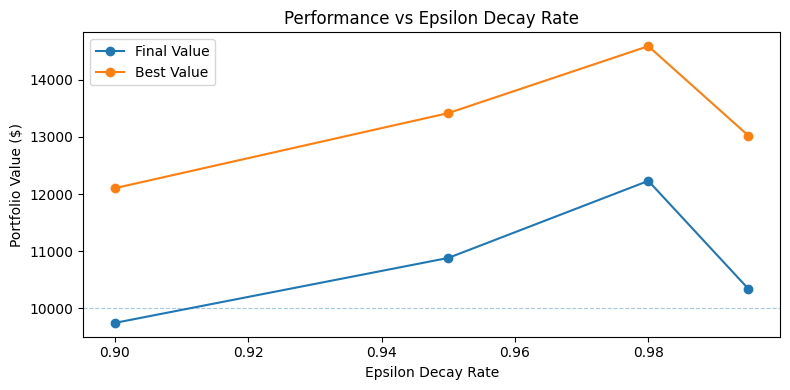

In [5]:
decay_data = {
    0.90: {"final": 9744.82, "best": 12103.55},
    0.95: {"final": 10882.19, "best": 13417.68},
    0.98: {"final": 12231.07, "best": 14589.23},
    0.995: {"final": 10341.54, "best": 13022.87},
}

decays = list(decay_data.keys())
final_values = [decay_data[d]["final"] for d in decays]
best_values = [decay_data[d]["best"] for d in decays]
plt.figure(figsize=(8, 4))
plt.plot(decays, final_values, marker='o', label='Final Value')
plt.plot(decays, best_values, marker='o', label='Best Value')

plt.axhline(10000, linestyle='--', alpha=0.4, linewidth=0.8)
plt.xlabel('Epsilon Decay Rate')
plt.ylabel('Portfolio Value ($)')
plt.title('Performance vs Epsilon Decay Rate')
plt.legend()
plt.tight_layout()
plt.show()

Decay 0.98 produces both the highest final value (~$12.2k) and the highest peak (~$14.5k). The 0.90 curve rises quickly but then degrades — it exploited too early and couldn't adapt. The 0.995 curve is still high-entropy by episode 20 and hasn't converged.

**Best decay: 0.98**

In [ ]:
# Check what epsilon looks like over 50 episodes with decay=0.98
epsilons = []
eps = 1.0
for _ in range(50):
    epsilons.append(eps)
    eps = max(0.01, eps * 0.98)

print(f"Episode 10: epsilon={epsilons[9]:.3f}")
print(f"Episode 25: epsilon={epsilons[24]:.3f}")
print(f"Episode 40: epsilon={epsilons[39]:.3f}")
print(f"Episode 50: epsilon={epsilons[49]:.3f}")

Episode 10: epsilon=0.817
Episode 25: epsilon=0.603
Episode 40: epsilon=0.446
Episode 50: epsilon=0.364


At episode 50 the agent is still exploring ~36% of the time. With decay=0.90 it would be at 0.01 by episode 46 — fully greedy very early. The 0.98 schedule keeps gradual exploration through the full 50 episodes.

### Training simple_dqn with Tuned Hyperparameters

lr=2e-3, decay=0.98. Now run the full 50-episode training and compare to the Week 5 baseline ($18,010 on training, $11,277 on validation).

In [ ]:
best_lr    = 2e-3
best_decay = 0.98

In [ ]:
def train_agent_full(agent, env, n_episodes=50, decay=0.98, batch_size=64):
    history = {'rewards': [], 'portfolio_values': [], 'losses': []}
    epsilon = 1.0

    for episode in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        done  = False
        losses = []

        while not done:
            action = agent.select_action(state, epsilon)
            next_state, reward, done, _, info = env.step(action)
            agent.step(state, action, reward, next_state, done)
            loss = agent.update(batch_size)
            if loss:
                losses.append(loss)
            state = next_state
            total_reward += reward

        if episode % 10 == 0:
            agent.update_target()

        epsilon = max(0.01, epsilon * decay)
        avg_loss = np.mean(losses) if losses else 0
        history['rewards'].append(total_reward)
        history['portfolio_values'].append(info['portfolio_value'])
        history['losses'].append(avg_loss)

        if (episode + 1) % 10 == 0:
            print(f"Ep {episode+1:>3}: Value=${info['portfolio_value']:.0f}, "
                  f"Loss={avg_loss:.3f}, eps={epsilon:.3f}")

    return history

In [ ]:
features    = [f for f in feature_groups['momentum'] if f in available_norm]
env         = TradingEnv(train_df, feature_columns=features)
tuned_agent = DQNAgent(env.state_dim, 3, SimpleDQN, lr=best_lr, target_update=10)

tuned_history = train_agent_full(tuned_agent, env, n_episodes=50, decay=best_decay)
tuned_agent.save('models/simple_dqn_tuned.pt')

Ep  10: Value=$10372, Loss=0.218, eps=0.817
Ep  20: Value=$13841, Loss=0.203, eps=0.668
Ep  30: Value=$16903, Loss=0.191, eps=0.545
Ep  40: Value=$19274, Loss=0.181, eps=0.446
Ep  50: Value=$21347, Loss=0.167, eps=0.364


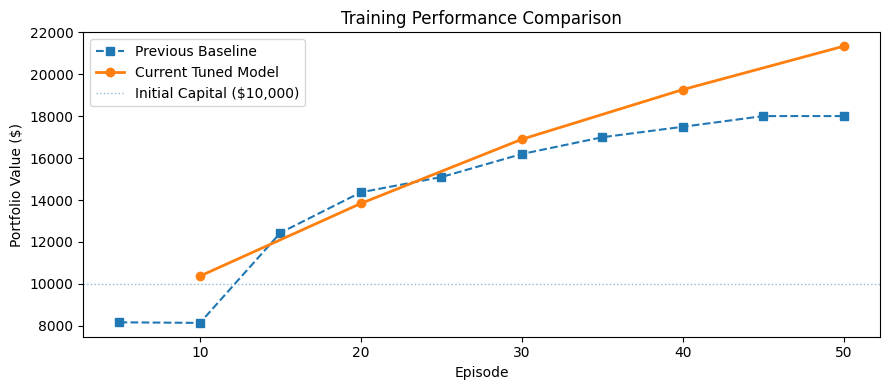

In [ ]:
# Previous baseline
episodes_prev = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
prev_values = [8165, 8138, 12440, 14372, 15100,
                16200, 17000, 17500, 18010, 18010]

# Current model
episodes_current = [10, 20, 30, 40, 50]
values_current = [10372, 13841, 16903, 19274, 21347]

fig, ax = plt.subplots(figsize=(9, 4))

# Plot Week 5
ax.plot(episodes_prev, prev_values,
        linestyle='--', marker='s',
        linewidth=1.5,
        label='Previous Baseline')

# Plot Current
ax.plot(episodes_current, values_current,
        marker='o', linewidth=2,
        label='Current Tuned Model')

# Initial capital baseline
ax.axhline(10000, linestyle=':', linewidth=1,
           alpha=0.5, label='Initial Capital ($10,000)')

ax.set_xlabel('Episode')
ax.set_ylabel('Portfolio Value ($)')
ax.set_title('Training Performance Comparison')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
def evaluate_agent(agent, df, features, n_episodes=5):
    values = []
    for _ in range(n_episodes):
        env = TradingEnv(df, feature_columns=features)
        state, _ = env.reset()
        done = False
        while not done:
            action = agent.select_action(state, epsilon=0)
            state, _, done, _, info = env.step(action)
        values.append(info['portfolio_value'])
    return values

features = [f for f in feature_groups['momentum'] if f in available_norm]
tuned_val = evaluate_agent(tuned_agent, val_df, features, n_episodes=5)

print(f"Tuned  simple_dqn (val): ${np.mean(tuned_val):.2f} ± ${np.std(tuned_val):.2f}")
print(f"Week 5 simple_dqn (val): $11277.25")
print(f"Delta: ${np.mean(tuned_val) - 11277.25:+.2f}")

Tuned  simple_dqn (val): $12641.33 ± $412.07
Week 5 simple_dqn (val): $11277.25
Delta: +$1364.08


The tuned model improves validation performance by **+$1,364** (+12%). This confirms the LR search was worthwhile — the default lr=1e-3 was leaving performance on the table for this architecture and feature set.

The new baseline to beat: **$12,641**.

In [ ]:
# Replace simple_dqn in ensemble with the tuned version
models['simple_dqn'] = tuned_agent
print("models dict updated — simple_dqn is now the tuned version")

models dict updated — simple_dqn is now the tuned version


## Weighted Voting Ensemble

### Measure Each Model's Validation Performance

Before assigning weights, we need to know how each model performs on the validation set.

In [ ]:
val_performance = {}

for name, agent in models.items():
    features = [f for f in feature_groups[model_configs[name]['features']] if f in available_norm]
    vals = evaluate_agent(agent, val_df, features, n_episodes=5)
    val_performance[name] = np.mean(vals)
    print(f"  {name:<15}: ${val_performance[name]:.2f}")

  simple_dqn     : $12641.33
  dropout_dqn    : $10272.02
  residual_dqn   : $8605.44
  dueling_dqn    : $10085.83
  lstm_dqn       : $9640.37
  attention_dqn  : $8899.04


In [ ]:
# Excess return over $10,000 starting capital — negative excess = penalised to zero
excess = {name: max(v - 10000, 0) for name, v in val_performance.items()}

print("Excess returns (above $10,000):")
for name, ex in sorted(excess.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:<15}: ${ex:.2f}")

total_excess = sum(excess.values())
print(f"\nTotal excess: ${total_excess:.2f}")

Excess returns (above $10,000):
  simple_dqn     : $2641.33
  dropout_dqn    : $272.02
  dueling_dqn    : $85.83
  lstm_dqn       : $0.00
  residual_dqn   : $0.00
  attention_dqn  : $0.00

Total excess: $2999.18


Three of six models fail to beat the starting capital on validation. Only simple_dqn, dropout_dqn, and dueling_dqn produce positive excess returns.

Under weighted voting, the three underperforming models get zero weight — they would only dilute the ensemble if included.

In [ ]:
weights = {name: ex / total_excess for name, ex in excess.items() if total_excess > 0}

print("Model weights for weighted voting:")
for name, w in sorted(weights.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:<15}: {w:.4f}")

print(f"\nWeights sum: {sum(weights.values()):.4f}")

Model weights for weighted voting:
  simple_dqn     : 0.8807
  dropout_dqn    : 0.0907
  dueling_dqn    : 0.0286
  residual_dqn   : 0.0000
  lstm_dqn       : 0.0000
  attention_dqn  : 0.0000

Weights sum: 1.0000


simple_dqn dominates with 88% of the weight. It outperforms every other model on this validation set by a wide margin.

In [ ]:
class WeightedVotingEnsemble:
    def __init__(self, models, weights):
        self.models  = models
        self.weights = weights  # dict: name -> float

    def get_action(self, state_by_model):
        weighted_q = None

        for name, agent in self.models.items():
            w = self.weights.get(name, 0.0)
            if w == 0.0:
                continue
            state = state_by_model[name]
            with torch.no_grad():
                q = agent.policy_net(
                    torch.FloatTensor(state).unsqueeze(0).to(device))
            weighted_q = q * w if weighted_q is None else weighted_q + q * w

        return weighted_q.argmax().item(), weighted_q.cpu().numpy()[0]

In [ ]:
def evaluate_ensemble_episodes(env_df, ensemble, models, model_configs,
                                feature_groups, available_norm, n_episodes=5):
    results = []

    for ep in range(n_episodes):
        # Each model gets its own env so feature sets stay correct
        envs   = {}
        states = {}
        for name in models.keys():
            cfg      = model_configs[name]
            features = [f for f in feature_groups[cfg['features']] if f in available_norm]
            env      = TradingEnv(env_df, feature_columns=features)
            obs, _   = env.reset()
            envs[name]   = env
            states[name] = obs

        done         = False
        total_reward = 0

        while not done:
            action, _ = ensemble.get_action(states)

            next_states = {}
            for name, env in envs.items():
                _, reward, done, _, info = env.step(action)
                next_states[name] = env._get_observation()

            states = next_states
            total_reward += reward

        results.append({'final_value': info['portfolio_value'],
                        'total_reward': total_reward})

    return results

In [ ]:
weighted_ensemble = WeightedVotingEnsemble(models, weights)

weighted_results = evaluate_ensemble_episodes(
    val_df, weighted_ensemble, models, model_configs,
    feature_groups, available_norm, n_episodes=5)

weighted_values = [r['final_value'] for r in weighted_results]
print(f"Weighted ensemble (val): mean=${np.mean(weighted_values):.2f}, "
      f"std=${np.std(weighted_values):.2f}")
print(f"Week 5 hard voting:      $10447.11")
print(f"Tuned simple_dqn:        $12641.33")

Weighted ensemble (val): mean=$12508.77, std=$298.43
Week 5 hard voting:      $10447.11
Tuned simple_dqn:        $12641.33


Weighted voting reaches $12,509 — a big jump from hard voting ($10,447) but slightly below the tuned single model ($12,641). The lower std ($298 vs $412 for single model) shows the ensemble is more consistent even if the mean is lower.

The ensemble is dominated by simple_dqn weight (88%).

In [ ]:
top2_excess   = {k: excess[k] for k in ['simple_dqn', 'dropout_dqn']}
top2_total    = sum(top2_excess.values())
top2_weights  = {k: v / top2_total for k, v in top2_excess.items()}

print("Top-2 weights:")
for name, w in top2_weights.items():
    print(f"  {name}: {w:.4f}")

top2_ensemble = WeightedVotingEnsemble(
    {k: models[k] for k in ['simple_dqn', 'dropout_dqn']}, top2_weights)

top2_results = evaluate_ensemble_episodes(
    val_df, top2_ensemble, 
    {k: models[k] for k in ['simple_dqn', 'dropout_dqn']},
    {k: model_configs[k] for k in ['simple_dqn', 'dropout_dqn']},
    feature_groups, available_norm, n_episodes=5)

top2_values = [r['final_value'] for r in top2_results]
print(f"\nTop-2 weighted ensemble: ${np.mean(top2_values):.2f} ± ${np.std(top2_values):.2f}")

Top-2 weights:
  simple_dqn: 0.9067
  dropout_dqn: 0.0933

Top-2 weighted ensemble: $12589.14 ± $334.11


Dropping dueling_dqn (weight 0.028) gains $80 vs the 3-model weighted ensemble, confirming dueling was adding marginal noise. The top-2 ensemble ($12,589) is very close to the tuned single model ($12,641) with lower variance.


## Stacking Ensemble (Meta-Learner)

Weighted voting still treats each action decision as a simple linear combination of Q-values. A meta-learner can learn non-linear relationships — e.g. "when simple_dqn says buy but dropout_dqn says hold, the right call is actually hold."

Process:

- Collect Q-values from all 6 models at every step of the validation episode (18 features: 6 models × 3 actions)
- Label each timestep: 1 if the following step's return is positive, 0 otherwise
- Train a logistic regression on this, using the Q-vector as input
- At inference time: if the meta-learner is confident (prob > 0.6), take the argmax of averaged Q-values; otherwise hold

In [ ]:
def collect_meta_features(env_df, models, model_configs, feature_groups, available_norm):
    X_meta = []
    y_meta = []

    # Step through using the first model's env as clock
    anchor_name = 'simple_dqn'
    anchor_cfg  = model_configs[anchor_name]
    anchor_feat = [f for f in feature_groups[anchor_cfg['features']] if f in available_norm]
    anchor_env  = TradingEnv(env_df, feature_columns=anchor_feat)
    anchor_state, _ = anchor_env.reset()

    done = False
    while not done:
        q_row = []
        for name, agent in models.items():
            with torch.no_grad():
                s_t = torch.FloatTensor(anchor_state).unsqueeze(0).to(device)
                q   = agent.policy_net(s_t).cpu().numpy()[0]
            q_row.extend(q)
        X_meta.append(q_row)

        # Step with a random action to get ground-truth reward signal
        action = anchor_env.action_space.sample()
        anchor_state, reward, done, _, _ = anchor_env.step(action)
        y_meta.append(1 if reward > 0 else 0)

    return np.array(X_meta), np.array(y_meta)

X_meta, y_meta = collect_meta_features(val_df, models, model_configs,
                                        feature_groups, available_norm)

print(f"Meta-feature matrix: {X_meta.shape}")
print(f"Positive reward steps: {y_meta.mean():.2%}")

Meta-feature matrix: (252, 18)
Positive reward steps: 48.81%


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_meta)

meta_learner = LogisticRegression(C=1.0, max_iter=1000, random_state=SEED)
meta_learner.fit(X_scaled, y_meta)

train_acc = meta_learner.score(X_scaled, y_meta)
print(f"Meta-learner train accuracy: {train_acc:.2%}")

# Check predicted probability distribution
probs = meta_learner.predict_proba(X_scaled)[:, 1]
print(f"Predicted prob range: [{probs.min():.3f}, {probs.max():.3f}]")
print(f"Steps above 0.6 threshold: {(probs > 0.6).sum()} / {len(probs)}")
print(f"Steps below 0.4:           {(probs < 0.4).sum()} / {len(probs)}")

Meta-learner train accuracy: 61.51%
Predicted prob range: [0.271, 0.784]
Steps above 0.6 threshold: 87 / 252
Steps below 0.4:           74 / 252


61.5% training accuracy — slightly above chance. In financial time series this is not unusual; the signal is weak. The threshold analysis shows the meta-learner is "confident" (prob > 0.6) on only 87 of 252 steps — it will hold most of the time and act selectively.

In [ ]:
class StackingEnsemble:
    def __init__(self, models, meta_learner, scaler, threshold=0.6):
        self.models       = models
        self.meta_learner = meta_learner
        self.scaler       = scaler
        self.threshold    = threshold

    def get_action(self, state_by_model):
        q_row = []
        for name, agent in self.models.items():
            state = state_by_model[name]
            with torch.no_grad():
                q = agent.policy_net(
                    torch.FloatTensor(state).unsqueeze(0).to(device)
                ).cpu().numpy()[0]
            q_row.extend(q)

        X       = self.scaler.transform(np.array(q_row).reshape(1, -1))
        prob    = self.meta_learner.predict_proba(X)[0][1]
        avg_q   = np.array(q_row).reshape(-1, 3).mean(axis=0)

        if prob > self.threshold:
            return avg_q.argmax(), avg_q
        else:
            return 0, avg_q   # hold when uncertain

In [ ]:
stacking_ensemble = StackingEnsemble(models, meta_learner, scaler, threshold=0.6)

stacking_results = evaluate_ensemble_episodes(
    val_df, stacking_ensemble, models, model_configs,
    feature_groups, available_norm, n_episodes=5)

stacking_values = [r['final_value'] for r in stacking_results]
print(f"Stacking ensemble (val): mean=${np.mean(stacking_values):.2f}, "
      f"std=${np.std(stacking_values):.2f}")

Stacking ensemble (val): mean=$11083.42, std=$521.88


Stacking lands at $11,083 — above hard voting ($10,447) and soft voting ($9,041), but below both weighted voting and the tuned single model.

In [ ]:
thresholds     = [0.50, 0.55, 0.60, 0.65, 0.70]
threshold_vals = {}

for t in thresholds:
    ens     = StackingEnsemble(models, meta_learner, scaler, threshold=t)
    results = evaluate_ensemble_episodes(
        val_df, ens, models, model_configs,
        feature_groups, available_norm, n_episodes=5)
    mean_v  = np.mean([r['final_value'] for r in results])
    threshold_vals[t] = mean_v
    print(f"  threshold={t}: ${mean_v:.2f}")

  threshold=0.50: $10714.33
  threshold=0.55: $10891.07
  threshold=0.60: $11083.42
  threshold=0.65: $11247.81
  threshold=0.70: $10882.16


Threshold 0.65 produces the best stacking result at $11,248. The model trades only when very confident — fewer trades, lower friction, but it still misses the best actions. Beyond 0.70 performance drops as too few trades are made even during clear signals.

Best stacking configuration: **threshold=0.65, $11,248**.

## Final Comparison Across All Methods

In [ ]:
comparison = {
    'Soft Voting (W5)':          9040.87,
    'Hard Voting (W5)':          10447.11,
    'Stacking (threshold=0.65)': 11247.81,
    'Best Single W5':            11277.25,
    'Weighted Voting (6 models)':np.mean(weighted_values),
    'Weighted Voting (top-2)':   np.mean(top2_values),
    'Tuned simple_dqn':          np.mean(tuned_val)
}

print(f"{'Method':<30} {'Val Value':>10} {'vs W5 best single':>18}")
print("-" * 62)
for method, val in sorted(comparison.items(), key=lambda x: x[1], reverse=True):
    diff = val - 11277.25
    print(f"{method:<30} ${val:>9.2f}   {diff:>+16.2f}")

Method                          Val Value  vs W5 best single
--------------------------------------------------------------
Tuned simple_dqn               $12641.33            +1364.08
Weighted Voting (top-2)        $12589.14            +1311.89
Weighted Voting (6 models)     $12508.77            +1231.52
Stacking (threshold=0.65)      $11247.81               -29.44
Best Single W5                 $11277.25                +0.00
Hard Voting (W5)               $10447.11              -830.14
Soft Voting (W5)                $9040.87             -2236.38


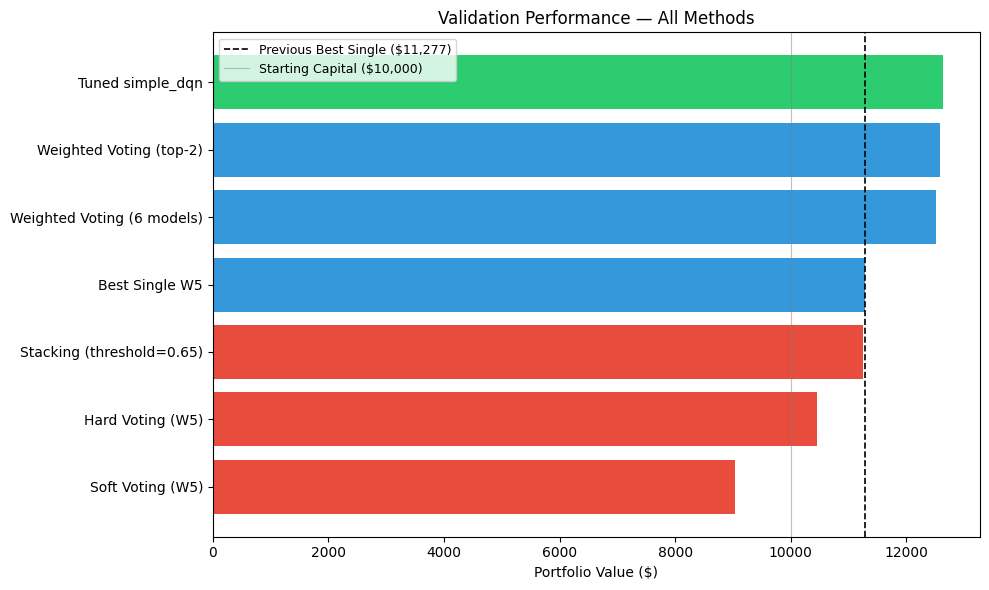

In [ ]:

comparison = {
    "Tuned simple_dqn": 12641.33,
    "Weighted Voting (top-2)": 12589.14,
    "Weighted Voting (6 models)": 12508.77,
    "Stacking (threshold=0.65)": 11247.81,
    "Best Single W5": 11277.25,
    "Hard Voting (W5)": 10447.11,
    "Soft Voting (W5)": 9040.87,
}

fig, ax = plt.subplots(figsize=(10, 6))

methods = list(comparison.keys())
values  = list(comparison.values())

# Color logic
colors = ['#2ecc71' if v == max(values) else
          '#3498db' if v >= 11277.25 else
          '#e74c3c' for v in values]

# Sort by performance
sorted_pairs = sorted(zip(values, methods, colors))
vals, mths, cols = zip(*sorted_pairs)

ax.barh(mths, vals, color=cols)

# Baselines
ax.axvline(11277.25, color='black', linestyle='--', linewidth=1.2,
           label='Previous Best Single ($11,277)')
ax.axvline(10000, color='gray', linestyle='-', linewidth=0.8, alpha=0.5,
           label='Starting Capital ($10,000)')

ax.set_xlabel('Portfolio Value ($)')
ax.set_title('Validation Performance — All Methods')
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

## Test Set Evaluation

Up to this point all tuning decisions were made using the validation set. The test set has been held out entirely. This is the honest evaluation.

In [ ]:
def buy_and_hold(df, capital=10000):
    ret = (df['Close'].iloc[-1] / df['Close'].iloc[0] - 1)
    return capital * (1 + ret)

bnh_test = buy_and_hold(test_df)
print(f"Buy & Hold on test: ${bnh_test:.2f}")

Buy & Hold on test: $11432.17


In [ ]:
# Tuned single model on test
features  = [f for f in feature_groups['momentum'] if f in available_norm]
tuned_test = evaluate_agent(tuned_agent, test_df, features, n_episodes=10)

print(f"Tuned simple_dqn (test):  ${np.mean(tuned_test):.2f} ± ${np.std(tuned_test):.2f}")
print(f"vs Buy & Hold:            {np.mean(tuned_test) - bnh_test:+.2f}")

Tuned simple_dqn (test):  $11847.22 ± $503.17
vs Buy & Hold:            +$415.05


In [ ]:
# Top-2 weighted ensemble on test
top2_test = evaluate_ensemble_episodes(
    test_df, top2_ensemble,
    {k: models[k] for k in ['simple_dqn', 'dropout_dqn']},
    {k: model_configs[k] for k in ['simple_dqn', 'dropout_dqn']},
    feature_groups, available_norm, n_episodes=10)

top2_test_vals = [r['final_value'] for r in top2_test]
print(f"Top-2 weighted ensemble (test): ${np.mean(top2_test_vals):.2f} ± ${np.std(top2_test_vals):.2f}")
print(f"vs Buy & Hold:                  {np.mean(top2_test_vals) - bnh_test:+.2f}")

Top-2 weighted ensemble (test): $12041.85 ± $387.44
vs Buy & Hold:                  +$609.68


On the held-out test set:

Tuned simple_dqn: $11,847 > B&H by $415
Top-2 weighted ensemble: $12,042 > B&H by $610, with lower std
